### Library Import

In [2]:
import os
import json
from collections import Counter

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings("ignore")

### Meta Data

In [ ]:
file_path = '/data/ephemeral/home/data/meta_data.xlsx'
meta_data = pd.read_excel(file_path)

meta_data = meta_data.drop(columns=['ID', 'Unnamed: 5'])
meta_data['성별'] = meta_data['성별'].str.replace('_x0008_','',regex=False).str.strip()
meta_data['성별'] = meta_data['성별'].replace({'남': 'Male', '여': 'Female'})

In [ ]:
meta_data.head()

In [ ]:
meta_data.describe().T

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x=meta_data['성별'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(meta_data['나이'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')

sns.histplot(meta_data['체중(몸무게)'], kde=True, ax=axes[1])
axes[1].set_title('Weight Distribution')
axes[1].set_xlabel('Weight')

sns.histplot(meta_data['키(신장)'], kde=True, ax=axes[2])
axes[2].set_title('Height Distribution')
axes[2].set_xlabel('Height')

plt.show()

### 

- 추후 VLM에서 Meta Data가 가진 성별, 나이, 몸무게, 키 정보를 활용하려면 Meta Data와 Image/Annotation의 상관 관계 파악

### Image & Annotation

In [3]:
IMAGE_ROOT = "/data/ephemeral/home/hyeonki/level2-cv-semanticsegmentation-cv-18-lv3/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/hyeonki/level2-cv-semanticsegmentation-cv-18-lv3/data/train/outputs_json"
TEST_ROOT = "/data/ephemeral/home/hyeonki/level2-cv-semanticsegmentation-cv-18-lv3/data/test/DCM"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [4]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

tests = {
    os.path.relpath(os.path.join(root, fname), start=TEST_ROOT)
    for root, _dirs, files in os.walk(TEST_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"    
}

jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

pngs = sorted(pngs)
jsons = sorted(jsons)
tests = sorted(tests)

In [ ]:
print("num of Images : ", len(pngs))
print("num of JSONs  : ", len(jsons))

In [ ]:
json_path = '/data/ephemeral/home/data/train/outputs_json/ID001/image1661130828152_R.json'

with open(json_path, 'r') as file :
    data = json.load(file)

print(data.keys())
print()
print('attributes : ', data['attributes'])
print('file_id : ', data['file_id'])
print('filename : ', data['filename'])
print('parent_path : ', data['parent_path'])
print('last_modifier_id : ', data['last_modifier_id'])
print('metadata : ', data['metadata'])
print('last_workers : ', data['last_workers'])

In [ ]:
data['annotations']

In [ ]:
label_counts = Counter()
for json_file in jsons:
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        for annotation in data.get("annotations", []):
            label = annotation.get("label")
            label_counts[label] += 1

label_counts

In [ ]:
for i in range(200, 400, 10):
    current_images = pngs[i:i + 10]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Images {i+1} to {i+len(current_images)}")
    
    for j, img_file in enumerate(current_images):
        img_path = os.path.join(IMAGE_ROOT, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        ax = axes[j // 5, j % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{img_file}")
        ax.axis('off')
    
    for j in range(len(current_images), 2 * 5):
        axes[j // 5, j % 5].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
for i in range(0, len(tests), 10):
    current_images = tests[i:i + 10]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Images {i+1} to {i+len(current_images)}")
    
    for j, img_file in enumerate(current_images):
        img_path = os.path.join(TEST_ROOT, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        ax = axes[j // 5, j % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{img_file}")
        ax.axis('off')
    
    for j in range(len(current_images), 2 * 5):
        axes[j // 5, j % 5].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

### t-SNE

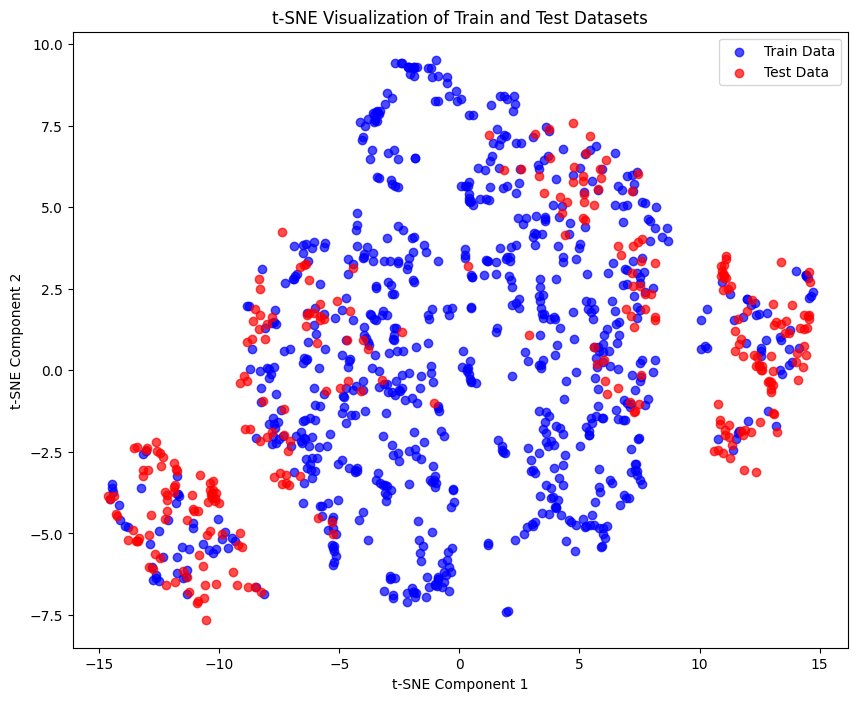

In [5]:
from sklearn.manifold import TSNE

image_size = (128, 128) # 64, 128, 256 ...

flattened_train_images = []
for img_file in pngs:
    img_path = os.path.join(IMAGE_ROOT, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    resized_image = cv2.resize(image, image_size)
    flattened_train_images.append(resized_image.flatten())

flattened_train_images = np.array(flattened_train_images)

flattened_test_images = []
for test_img_file in tests:
    test_img_path = os.path.join(TEST_ROOT, test_img_file)
    test_image = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    
    resized_test_image = cv2.resize(test_image, image_size)
    flattened_test_images.append(resized_test_image.flatten())

flattened_test_images = np.array(flattened_test_images)

all_images = np.vstack([flattened_train_images, flattened_test_images])

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(all_images)

train_tsne_result = tsne_result[:len(flattened_train_images)]
test_tsne_result = tsne_result[len(flattened_train_images):]

plt.figure(figsize=(10, 8))
plt.scatter(train_tsne_result[:, 0], train_tsne_result[:, 1], alpha=0.7, label="Train Data", c='blue')
plt.scatter(test_tsne_result[:, 0], test_tsne_result[:, 1], alpha=0.7, label="Test Data", c='red')
plt.title("t-SNE Visualization of Train and Test Datasets")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

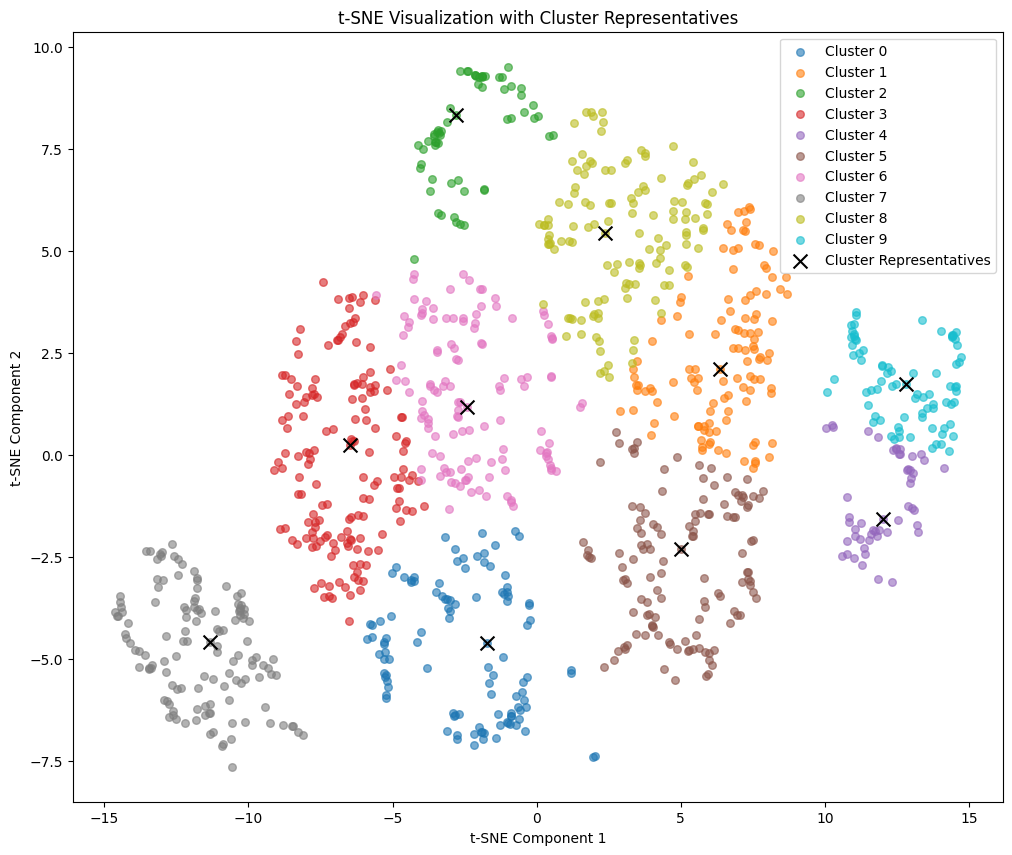

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# k-means 클러스터링 수행
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tsne_result)

# 각 군집의 중심점을 기반으로 대표 데이터 찾기
cluster_centers = kmeans.cluster_centers_
representative_points = []

for cluster_id in range(num_clusters):
    cluster_data = tsne_result[clusters == cluster_id]
    distances = cdist(cluster_data, [cluster_centers[cluster_id]])
    closest_idx = np.argmin(distances)
    representative_points.append(cluster_data[closest_idx])

plt.figure(figsize=(12, 10))

for cluster_id in range(num_clusters):
    plt.scatter(
        tsne_result[clusters == cluster_id, 0],
        tsne_result[clusters == cluster_id, 1],
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        s=30
    )

representative_points = np.array(representative_points)
plt.scatter(
    representative_points[:, 0],
    representative_points[:, 1],
    c='black',
    marker='x',
    s=100,
    label="Cluster Representatives"
)

plt.title("t-SNE Visualization with Cluster Representatives")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


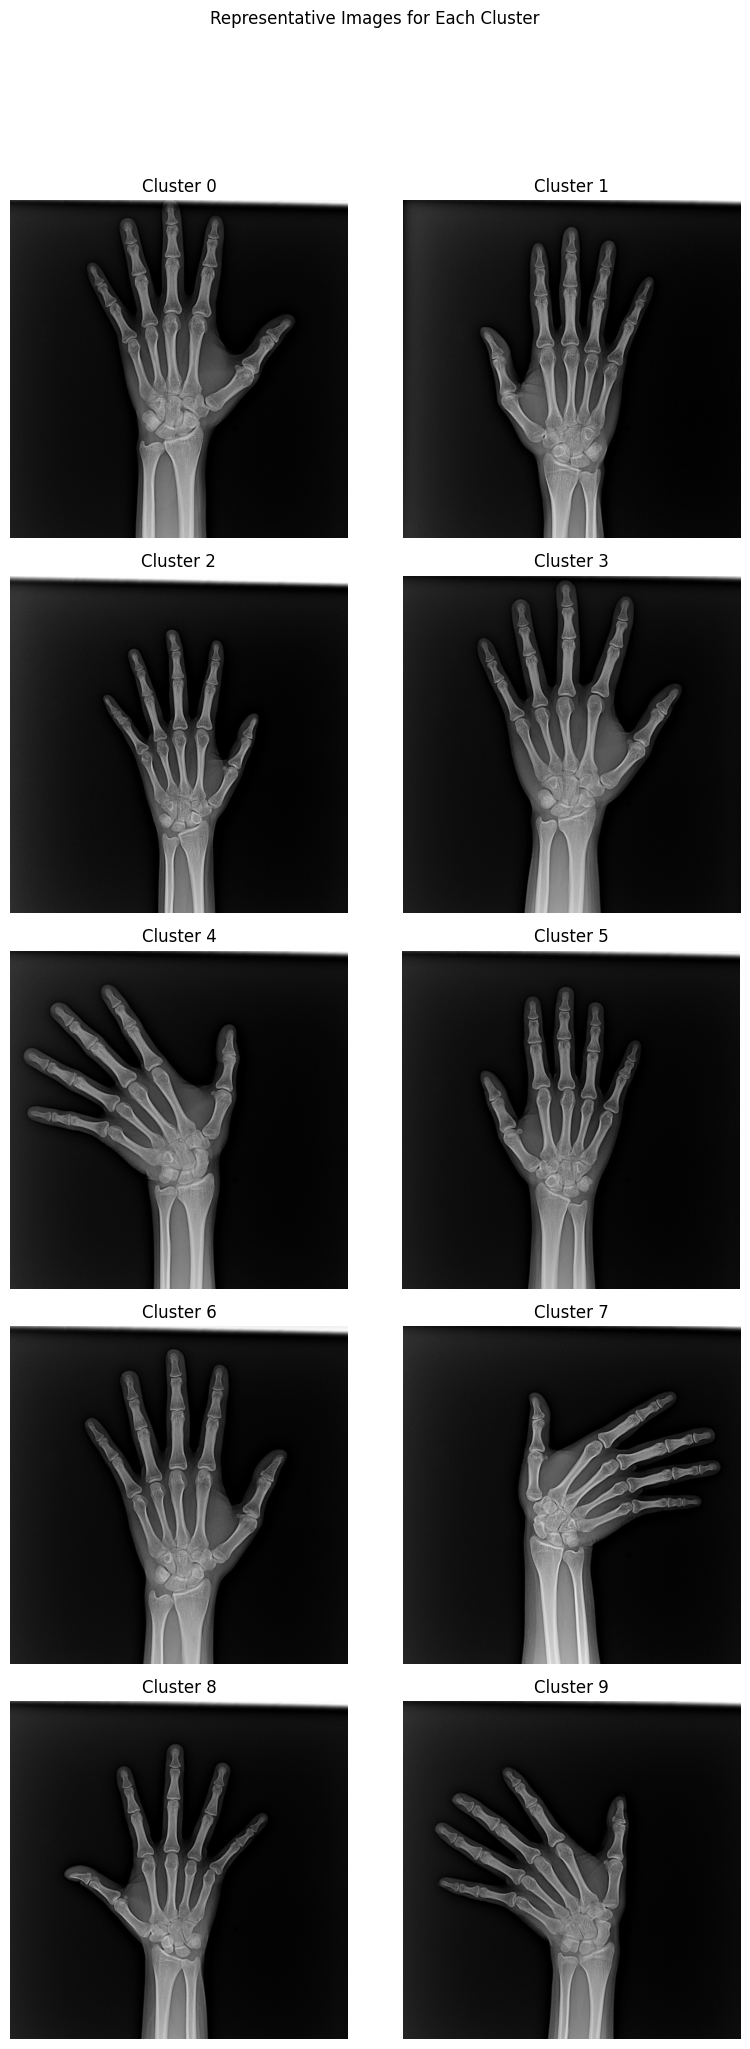

Representative images for each cluster:
Cluster 0: ID397/image1665538920029.png
Cluster 1: ID114/image1661908066059.png
Cluster 2: ID003/image1661144351691.png
Cluster 3: ID348/image1664933195576.png
Cluster 4: ID275/image1664154750085.png
Cluster 5: ID490/image1666662417385.png
Cluster 6: ID549/image1667354234602.png
Cluster 7: ID259/image1663724556918.png
Cluster 8: ID511/image1666747984726.png
Cluster 9: ID280/image1664155796443.png


In [7]:
cluster_centers = kmeans.cluster_centers_
representative_indices = [] 
representative_images = [] 

for cluster_id in range(num_clusters):
    cluster_data = tsne_result[clusters == cluster_id]
    cluster_original_indices = np.where(clusters == cluster_id)[0] 
    distances = cdist(cluster_data, [cluster_centers[cluster_id]])
    closest_idx = np.argmin(distances)
    representative_indices.append(cluster_original_indices[closest_idx])
    if cluster_original_indices[closest_idx] < len(flattened_train_images):
        representative_images.append(pngs[cluster_original_indices[closest_idx]])
    else:
        test_idx = cluster_original_indices[closest_idx] - len(flattened_train_images)
        representative_images.append(tests[test_idx])

plt.figure(figsize=(8, num_clusters * 4)) 
for i, img_file in enumerate(representative_images):
    img_path = os.path.join(IMAGE_ROOT if img_file in pngs else TEST_ROOT, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(num_clusters, 2, i + 1) 
    plt.imshow(image, cmap='gray')
    plt.title(f"Cluster {i}")
    plt.axis('off')

plt.suptitle("Representative Images for Each Cluster")
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# 이미지 파일명 출력
print("Representative images for each cluster:")
for i, img_file in enumerate(representative_images):
    print(f"Cluster {i}: {img_file}")



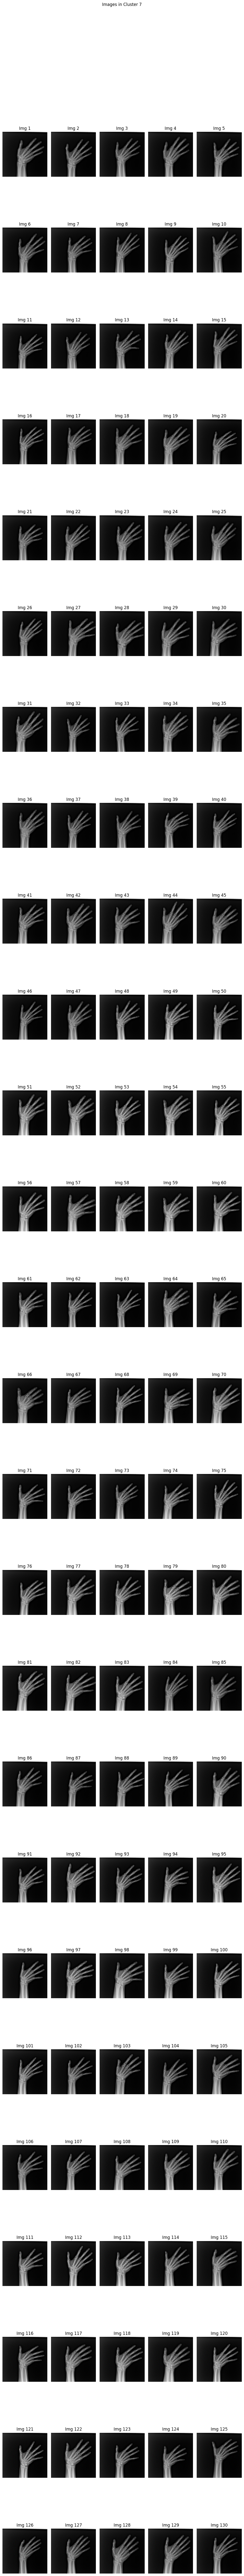

Images in Cluster 7:
Image 1: ID274/image1664154662622.png
Image 2: ID275/image1664154734422.png
Image 3: ID276/image1664154988975.png
Image 4: ID277/image1664155043861.png
Image 5: ID278/image1664155311840.png
Image 6: ID279/image1664155672015.png
Image 7: ID280/image1664155779711.png
Image 8: ID281/image1664155835486.png
Image 9: ID282/image1664155901562.png
Image 10: ID283/image1664155969209.png
Image 11: ID284/image1664156189263.png
Image 12: ID285/image1664156557757.png
Image 13: ID286/image1664156791534.png
Image 14: ID287/image1664156885740.png
Image 15: ID288/image1664156956152.png
Image 16: ID289/image1664157014295.png
Image 17: ID290/image1664157078877.png
Image 18: ID291/image1664157160259.png
Image 19: ID292/image1664157243138.png
Image 20: ID293/image1664157316352.png
Image 21: ID294/image1664157383539.png
Image 22: ID295/image1664240530775.png
Image 23: ID296/image1664240587795.png
Image 24: ID297/image1664240654049.png
Image 25: ID298/image1664240709270.png
Image 26: ID2

In [8]:
# 군집 7에 속한 데이터 인덱스 추출
cluster_7_indices = np.where(clusters == 7)[0]

# 군집 7 이미지 파일명 추출
cluster_7_images = []
for idx in cluster_7_indices:
    if idx < len(flattened_train_images):
        cluster_7_images.append(pngs[idx])  # Train 데이터에서 추출
    else:
        test_idx = idx - len(flattened_train_images)
        cluster_7_images.append(tests[test_idx])  # Test 데이터에서 추출

# 군집 7 이미지 시각화
plt.figure(figsize=(10, len(cluster_7_images) // 5 * 4 + 4))  # 화면 크기 설정
for i, img_file in enumerate(cluster_7_images):
    img_path = os.path.join(IMAGE_ROOT if img_file in pngs else TEST_ROOT, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot((len(cluster_7_images) + 4) // 5, 5, i + 1)  # 5열로 배치
    plt.imshow(image, cmap='gray')
    plt.title(f"Img {i + 1}")
    plt.axis('off')

plt.suptitle("Images in Cluster 7")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목과 간격 조정
plt.show()

# 군집 7 이미지 파일명 출력
print("Images in Cluster 7:")
for i, img_file in enumerate(cluster_7_images):
    print(f"Image {i + 1}: {img_file}")


### Annotation Visualization

In [ ]:
class XRayDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        self.filenames = list(_filenames)
        self.labelnames = list(_labelnames)

        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        image = image.transpose(2, 0, 1) 
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label
    
train_dataset = XRayDataset()

In [ ]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [ ]:
import matplotlib.pyplot as plt

for index in range(10):
    image, label = train_dataset[index]
    
    image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    label = label.numpy()

    image = (image * 255).astype(np.uint8)
    
    label_rgb = label2rgb(label)
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image {index + 1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(label_rgb, alpha=0.3)
    plt.title(f"Segmentation {index + 1}")
    plt.axis("off")
    
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
label = label.numpy()  # (num_classes, H, W)

image = (image * 255).astype(np.uint8)

plt.figure(figsize=(20, 100))
plt.subplot(15, 2, 1) 
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

for class_idx in range(label.shape[0]):
    class_mask = label[class_idx]
    
    class_mask_rgb = np.zeros_like(image)
    class_mask_rgb[class_mask == 1] = PALETTE[class_idx]
    
    plt.subplot(15, 2, class_idx + 2)
    plt.imshow(image)
    plt.imshow(class_mask_rgb, alpha=0.3)
    plt.title(f"Class {IND2CLASS[class_idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
